In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import sys

# Add the directory containing fs.py to the Python path
sys.path.append('./modules')

# Assuming FuzzySystemLayer and create_fuzzy_model are defined in fs.py
from fs import FuzzySystemLayer, create_fuzzy_model

# Paths to the prepped data files
base_path = './data/prepped_data/'  # Adjusted base path to where your files are now
X_train_path = base_path + 'X_train.csv'
X_test_path = base_path + 'X_test.csv'
y_train_path = base_path + 'y_train.csv'
y_test_path = base_path + 'y_test.csv'

# Loading the datasets
X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

# Assuming the last columns of X_train and X_test are year, month, day, hour for reconstructing the datetime index
X_train['datetime'] = pd.to_datetime(X_train[['year', 'month', 'day', 'hour']])
X_test['datetime'] = pd.to_datetime(X_test[['year', 'month', 'day', 'hour']])
y_train.index = pd.to_datetime(X_train['datetime'])
y_test.index = pd.to_datetime(X_test['datetime'])

# Exclude non-numerical columns before scaling
columns_to_scale = X_train.columns.difference(['year', 'month', 'day', 'hour', 'datetime'])

# Initialize the scaler for the features
scaler_X = MinMaxScaler()

# Scale 'X' features (excluding non-numerical columns)
X_train_scaled = scaler_X.fit_transform(X_train[columns_to_scale])
X_test_scaled = scaler_X.transform(X_test[columns_to_scale])

# Initialize a separate scaler for the target variable
scaler_y = MinMaxScaler()

# Scale 'y' (the target variable)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import optuna
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
# Assuming FS_Regressor has been imported from the fs module


# Determine the optimal number of clusters (e.g., using domain knowledge, elbow method, etc.)
n_clusters = 3  # This is a placeholder; adjust based on your analysis

# Steps for cluster determination remain the same
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train_scaled)
cluster_centers = kmeans.cluster_centers_
def create_objective(X_train_scaled, y_train_scaled, cluster_centers):
    def objective(trial):
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
        initializer_stddev = trial.suggest_float('initializer_stddev', 0.01, 0.1)
        
        model = create_fuzzy_model(
            input_dim=X_train_scaled.shape[1],
            cluster_centers=cluster_centers,
            output_dim=1,
            learning_rate=learning_rate,
            initializer_stddev=initializer_stddev
        )
        
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        history = model.fit(
            X_train_scaled,
            y_train_scaled,
            validation_split=0.2,
            epochs=50,
            callbacks=[early_stopping],
            verbose=0
        )
        
        best_val_loss = min(history.history['val_loss'])
        return best_val_loss
    return objective

objective_function = create_objective(X_train_scaled, y_train_scaled, cluster_centers)
study = optuna.create_study(direction='minimize')

# Wrap the study.optimize call with tqdm for a progress bar
n_trials = 50
with tqdm(total=n_trials, desc="Optimize") as pbar:
    def callback(study, trial):
        # Update the progress bar after each trial
        pbar.update(1)
    study.optimize(objective_function, n_trials=n_trials, callbacks=[callback])

print('Number of finished trials:', len(study.trials))
# After optimization process
best_hyperparams = study.best_trial.params
print(f"Best hyperparameters: {best_hyperparams}")

# Now, you can safely use `best_hyperparams` to retrain your model
best_model = create_fuzzy_model(
    input_dim=X_train_scaled.shape[1],
    cluster_centers=cluster_centers,
    output_dim=1,
    learning_rate=best_hyperparams['learning_rate'],
    initializer_stddev=best_hyperparams['initializer_stddev']
)

best_model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2)

y_pred_scaled = best_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
print(f"Mean Squared Error (MSE) on Test Set: {mse_test}")
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")




[I 2024-03-18 23:25:56,654] A new study created in memory with name: no-name-43b6f631-9355-4c3a-8965-0c5b6cfe7ed5


Optimize:   0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-03-18 23:26:01,248] Trial 0 finished with value: 0.02375805750489235 and parameters: {'learning_rate': 0.0003448574732355358, 'initializer_stddev': 0.023351880938001873}. Best is trial 0 with value: 0.02375805750489235.
[I 2024-03-18 23:26:04,511] Trial 1 finished with value: 0.022669125348329544 and parameters: {'learning_rate': 0.0009203579465323847, 'initializer_stddev': 0.0850442623418636}. Best is trial 1 with value: 0.022669125348329544.
[I 2024-03-18 23:26:07,809] Trial 2 finished with value: 0.022489698603749275 and parameters: {'learning_rate': 0.0007138834268025522, 'initializer_stddev': 0.05486955954654193}. Best is trial 2 with value: 0.022489698603749275.
[I 2024-03-18 23:26:13,501] Trial 3 finished with value: 0.022667404264211655 and parameters: {'learning_rate': 0.00020653437120105267, 'initializer_stddev': 0.03543785049444018}. Best is trial 2 with value: 0.022489698603749275.
[I 2024-03-18 23:26:17,927] Trial 4 finished with value: 0.022882305085659027 and par

Number of finished trials: 50
Best hyperparameters: {'learning_rate': 0.00017030928310703358, 'initializer_stddev': 0.07055412310170907}
Epoch 1/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 299us/step - loss: 0.0162 - val_loss: 0.2881
Epoch 2/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - loss: 0.0093 - val_loss: 0.1685
Epoch 3/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - loss: 0.0054 - val_loss: 0.0870
Epoch 4/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - loss: 0.0031 - val_loss: 0.0447
Epoch 5/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - loss: 0.0022 - val_loss: 0.0283
Epoch 6/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - loss: 0.0020 - val_loss: 0.0240
Epoch 7/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - loss: 0.0020 - val_loss: 0.0227
Epoch 8/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - loss: 0.0020 - val_loss: 0.0224
Epoch 9/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - loss: 0.0019 - val_loss: 0.0223
Epoch 10/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 

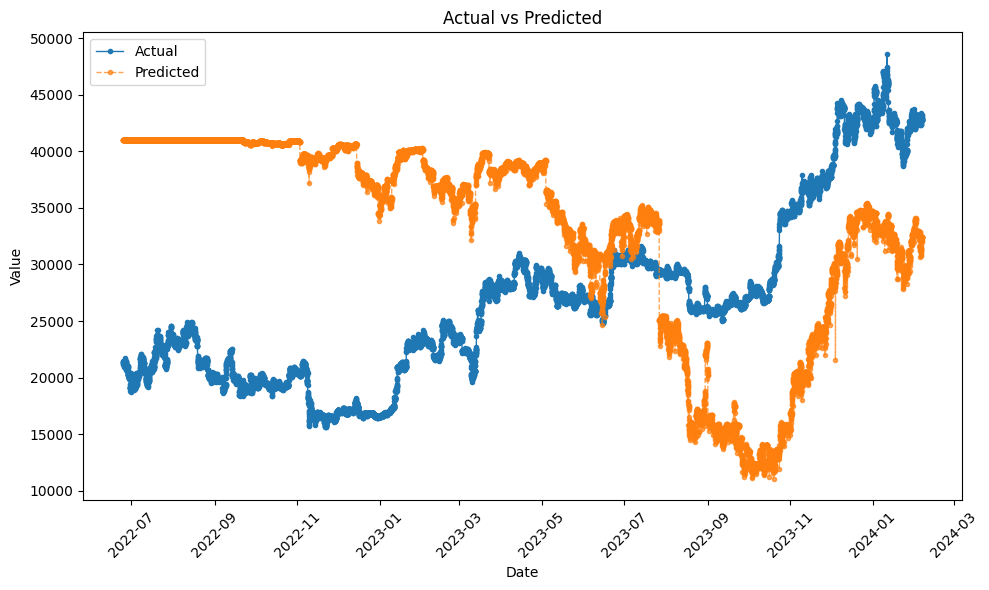

In [3]:
import matplotlib.pyplot as plt
y_test_original = y_test.values.flatten()[:len(y_pred)]  # Adjust length if necessary
# Assuming y_test_original and y_pred are correctly aligned with these dates
test_dates_aligned = X_test['datetime'].values[-len(y_pred):]

plt.figure(figsize=(10, 6))
plt.plot(test_dates_aligned, y_test_original, label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(test_dates_aligned, y_pred, label='Predicted', alpha=0.7, marker='.', linestyle='--', linewidth=1)
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Improve readability of the date labels
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()